In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Функция оценки работы модели

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(12,7))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

### Пути к файлам

In [5]:
TRAIN_DS_PATH = '/Users/andrewvolkov/Documents/Prog/Datasets/real_estate_project/train.csv'
TEST_DS_PATH = '/Users/andrewvolkov/Documents/Prog/Datasets/real_estate_project/test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DS_PATH).set_index('Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
train_df.shape

(10000, 19)

In [8]:
test_df = pd.read_csv(TEST_DS_PATH).set_index('Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [9]:
test_df.shape

(5000, 18)

### Запомним изначальные id 

In [10]:
test_ids = list(test_df.index)

In [11]:
train_ids = list(train_df.index)

### Объединение таблиц

In [12]:
full_df = pd.concat([train_df, test_df])

In [13]:
full_df.shape

(15000, 19)

In [14]:
full_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
14038,35,0.089040,B,B,7,NaN,0,9.0,1969,6.0,29.442751,184966.930730,2.0,11,B,33,7976,5,47.981561
15053,41,0.000070,B,B,7,240.0,1,9.0,1978,8.0,40.049543,300009.450063,3.0,16,B,46,10309,1,65.683640
4765,53,0.049637,B,B,8,229.0,1,12.0,1968,0.0,29.197612,220925.908524,2.0,3,B,34,7759,0,44.947953
5809,58,0.437885,B,B,8,1084.0,0,17.0,1977,9.0,52.731512,175616.227217,2.0,5,B,23,5735,3,53.352981
10783,99,0.012339,B,B,11,2078.0,2,12.0,1976,7.0,23.776169,150226.531644,1.0,4,B,35,5776,1,39.649192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,0.000170,B,B,5,NaN,1,9.0,1973,6.0,50.809797,NaN,3.0,1,B,36,5992,0,67.133911
4695,1,0.007122,B,B,12,NaN,0,17.0,2017,10.0,21.807061,NaN,1.0,1,B,1,264,0,40.198472
5783,12,0.090799,B,B,23,NaN,5,22.0,1989,9.0,48.282625,NaN,3.0,15,B,74,19083,2,77.842178


 ### Типы данных

In [15]:
full_df.dtypes

DistrictId         int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Floor              int64
Healthcare_1     float64
Helthcare_2        int64
HouseFloor       float64
HouseYear          int64
KitchenSquare    float64
LifeSquare       float64
Price            float64
Rooms            float64
Shops_1            int64
Shops_2           object
Social_1           int64
Social_2           int64
Social_3           int64
Square           float64
dtype: object

In [16]:
full_df['DistrictId'] = full_df['DistrictId'].astype(str)

### Обзор данных

In [17]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
Healthcare_1,7825.0,1144.162428,1029.296278,0.000000,350.000000,900.000000,1548.000000,4.849000e+03
Helthcare_2,15000.0,1.319467,1.489012,0.000000,0.000000,1.000000,2.000000,6.000000e+00
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
LifeSquare,11846.0,36.851792,71.120183,0.333490,22.896130,32.822810,45.144624,7.480592e+03
Price,10000.0,214138.857399,92872.293865,59174.778028,153872.633942,192269.644879,249135.462171,6.332335e+05
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01


In [18]:
full_df.describe(include='O').T

,count,unique,top,freq
DistrictId,15000,212,27,1242
Ecology_2,15000,2,B,14855
Ecology_3,15000,2,B,14576
Shops_2,15000,2,B,13763


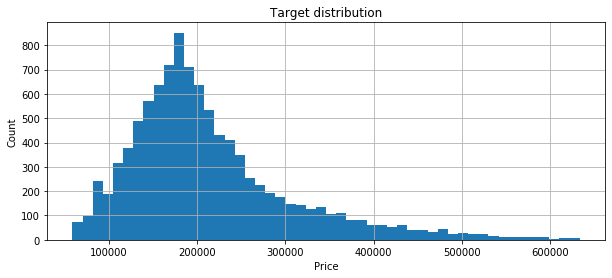

In [19]:
plt.figure(figsize = (10, 4))

full_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

### Анализ и обработка выбросов

##### Rooms

In [20]:
full_df['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [21]:
full_df['Rooms'].median()

2.0

In [22]:
full_df.loc[full_df['Rooms'].isin([0, 10, 19, 17]), 'Rooms'] = full_df['Rooms'].median()

In [23]:
full_df['Rooms'].value_counts()

2.0    5924
1.0    5474
3.0    3334
4.0     240
5.0      25
6.0       3
Name: Rooms, dtype: int64

##### HouseFloor

In [24]:
full_df[full_df['HouseFloor'] < full_df['Floor']]

# Строки, в которых этаж дома меньше, чем этаж квартиры

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
11993,74,0.075779,B,B,14,NaN,0,0.0,1977,0.0,NaN,221244.156664,2.0,2,B,6,1437,3,80.312926
10953,27,0.072158,B,B,5,NaN,0,4.0,1977,1.0,52.408027,140647.565937,1.0,0,A,2,629,1,53.769097
2119,27,0.051815,B,B,6,NaN,0,5.0,1983,5.0,31.993964,117000.381287,2.0,0,B,5,1227,0,49.360648
11935,27,0.211401,B,B,15,NaN,0,1.0,1977,1.0,NaN,127200.026511,2.0,1,B,9,1892,0,64.711835
6641,54,0.006076,B,B,2,645.0,6,0.0,1977,0.0,NaN,571069.052600,3.0,6,B,30,5285,0,118.907612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,95,0.000699,B,B,6,4129.0,0,0.0,1977,0.0,NaN,NaN,1.0,3,B,14,3369,24,45.542940
2591,39,0.428826,B,B,10,730.0,0,9.0,1972,6.0,30.191691,NaN,2.0,2,B,25,5011,8,44.203592
14562,113,0.307467,B,A,6,325.0,2,5.0,1969,5.0,27.058739,NaN,2.0,5,B,30,5048,9,46.627882


In [25]:
bad_housefloor_ids = full_df[full_df['HouseFloor'] < full_df['Floor']].index
bad_housefloor_ids

# список индексов, в которых нужно исправить этажность здания

Int64Index([11993, 10953,  2119, 11935,  6641,  4378,  6486,  9371, 10521,
            10103,
            ...
             9157,  5820, 16087, 15181, 16064,  4723,  2591, 14562,  5783,
             4780],
           dtype='int64', name='Id', length=2709)

In [26]:
full_df.loc[full_df['HouseFloor'].index.isin(bad_housefloor_ids), 'HouseFloor'] = full_df['Floor']

In [27]:
full_df[full_df.index == 11993]

# Проверка отработанной команды

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
11993,74,0.075779,B,B,14,NaN,0,14.0,1977,0.0,NaN,221244.156664,2.0,2,B,6,1437,3,80.312926


##### HouseYear

In [28]:
full_df['HouseYear'].sort_values().unique()

array([    1908,     1909,     1910,     1911,     1912,     1914,
           1916,     1917,     1918,     1919,     1920,     1926,
           1927,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1943,     1947,
           1948,     1949,     1950,     1951,     1952,     1953,
           1954,     1955,     1956,     1957,     1958,     1959,
           1960,     1961,     1962,     1963,     1964,     1965,
           1966,     1967,     1968,     1969,     1970,     1971,
           1972,     1973,     1974,     1975,     1976,     1977,
           1978,     1979,     1980,     1981,     1982,     1983,
           1984,     1985,     1986,     1987,     1988,     1989,
           1990,     1991,     1992,     1993,     1994,     1995,
           1996,     1997,     1998,     1999,     2000,     2001,
           2002,     2003,     2004,     2005,     2006,     2

In [29]:
full_df.loc[full_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [30]:
full_df.loc[full_df['HouseYear'] > 2020, 'HouseYear'] = 2020

##### LifeSquare, KitchenSquare

In [31]:
full_df['LifeSquare'].describe().T

count    11846.000000
mean        36.851792
std         71.120183
min          0.333490
25%         22.896130
50%         32.822810
75%         45.144624
max       7480.592129
Name: LifeSquare, dtype: float64

In [32]:
full_df.loc[full_df['LifeSquare'] < 8, 'LifeSquare'] = 8

In [33]:
full_df['KitchenSquare'].describe().T

count    15000.000000
mean         6.174467
std         24.016979
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [34]:
full_df.loc[full_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

### Обработка пропусков

##### Healthcare_1

In [35]:
full_df['Healthcare_1'].describe().T

count    7825.000000
mean     1144.162428
std      1029.296278
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [36]:
full_df['Healthcare_1'].isna().value_counts()

False    7825
True     7175
Name: Healthcare_1, dtype: int64

In [37]:
full_df['Healthcare_1'].median()

900.0

In [38]:
full_df.loc[full_df['Healthcare_1'].isna(), 'Healthcare_1'] = full_df['Healthcare_1'].median()

In [39]:
full_df['Healthcare_1'].isna().value_counts()

False    15000
Name: Healthcare_1, dtype: int64

##### LifeSquare

In [40]:
full_df['LifeSquare'].isnull().value_counts()

False    11846
True      3154
Name: LifeSquare, dtype: int64

In [41]:
med_square_diff = full_df['Square'].median() - full_df['LifeSquare'].median()
med_square_diff

19.822947187022912

In [42]:
full_df.loc[full_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    full_df.loc[full_df['LifeSquare'].isnull(), 'Square'] 
    - med_square_diff)


In [43]:
full_df['LifeSquare'].isnull().value_counts()

False    15000
Name: LifeSquare, dtype: int64

In [44]:
full_df.isna().sum()

# проверка на остуствие пропусков

DistrictId          0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Floor               0
Healthcare_1        0
Helthcare_2         0
HouseFloor          0
HouseYear           0
KitchenSquare       0
LifeSquare          0
Price            5000
Rooms               0
Shops_1             0
Shops_2             0
Social_1            0
Social_2            0
Social_3            0
Square              0
dtype: int64

### Обработка категориальных признаков

In [45]:
full_df['Ecology_2'] = full_df['Ecology_2'].replace({'A':0, 'B':1})
full_df['Ecology_3'] = full_df['Ecology_3'].replace({'A':0, 'B':1})
full_df['Shops_2'] = full_df['Shops_2'].replace({'A':0, 'B':1})

In [46]:
full_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
14038,35,0.089040,1,1,7,900.0,0,9.0,1969,6.0,29.442751,184966.930730,2.0,11,1,33,7976,5,47.981561
15053,41,0.000070,1,1,7,240.0,1,9.0,1978,8.0,40.049543,300009.450063,3.0,16,1,46,10309,1,65.683640
4765,53,0.049637,1,1,8,229.0,1,12.0,1968,3.0,29.197612,220925.908524,2.0,3,1,34,7759,0,44.947953
5809,58,0.437885,1,1,8,1084.0,0,17.0,1977,9.0,52.731512,175616.227217,2.0,5,1,23,5735,3,53.352981
10783,99,0.012339,1,1,11,2078.0,2,12.0,1976,7.0,23.776169,150226.531644,1.0,4,1,35,5776,1,39.649192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,0.000170,1,1,5,900.0,1,9.0,1973,6.0,50.809797,NaN,3.0,1,1,36,5992,0,67.133911
4695,1,0.007122,1,1,12,900.0,0,17.0,2017,10.0,21.807061,NaN,1.0,1,1,1,264,0,40.198472
5783,12,0.090799,1,1,23,900.0,5,23.0,1989,9.0,48.282625,NaN,3.0,15,1,74,19083,2,77.842178


### Разделение обратно на train и test

In [47]:
train_df = full_df.loc[full_df.index.isin(train_ids)]

In [48]:
train_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
14038,35,0.089040,1,1,7,900.0,0,9.0,1969,6.0,29.442751,184966.930730,2.0,11,1,33,7976,5,47.981561
15053,41,0.000070,1,1,7,240.0,1,9.0,1978,8.0,40.049543,300009.450063,3.0,16,1,46,10309,1,65.683640
4765,53,0.049637,1,1,8,229.0,1,12.0,1968,3.0,29.197612,220925.908524,2.0,3,1,34,7759,0,44.947953
5809,58,0.437885,1,1,8,1084.0,0,17.0,1977,9.0,52.731512,175616.227217,2.0,5,1,23,5735,3,53.352981
10783,99,0.012339,1,1,11,2078.0,2,12.0,1976,7.0,23.776169,150226.531644,1.0,4,1,35,5776,1,39.649192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,32,0.135650,1,1,6,350.0,3,6.0,1968,5.0,30.476203,196684.316040,2.0,11,1,46,7960,6,50.401785
6159,18,0.000000,1,1,13,900.0,0,13.0,2000,9.0,20.539216,189050.289571,1.0,5,0,30,5562,0,41.521546
5123,27,0.072158,1,1,12,900.0,0,16.0,2015,3.0,28.116060,159143.805370,1.0,0,0,2,629,1,47.939008


In [49]:
test_df = full_df.loc[full_df.index.isin(test_ids)]

In [50]:
del test_df['Price']

In [51]:
test_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,
725,58,0.310199,1,1,6,900.0,0,14.0,1972,6.0,33.432782,2.0,0,1,11,2748,1,49.882643
15856,74,0.075779,1,1,6,900.0,0,6.0,1977,3.0,49.440236,2.0,2,1,6,1437,3,69.263183
5480,190,0.000000,1,1,2,4702.0,5,5.0,1909,12.0,15.948246,1.0,5,1,30,7538,87,13.597819
15664,47,0.101872,1,1,22,900.0,3,22.0,2007,9.0,51.940842,2.0,3,1,23,4583,3,73.046609
14275,27,0.072158,1,1,17,900.0,0,17.0,2017,3.0,43.387569,1.0,0,0,2,629,1,47.527111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,0.000170,1,1,5,900.0,1,9.0,1973,6.0,50.809797,3.0,1,1,36,5992,0,67.133911
4695,1,0.007122,1,1,12,900.0,0,17.0,2017,10.0,21.807061,1.0,1,1,1,264,0,40.198472
5783,12,0.090799,1,1,23,900.0,5,23.0,1989,9.0,48.282625,3.0,15,1,74,19083,2,77.842178


### train val split

In [52]:
train_df.columns.tolist()

['DistrictId',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Floor',
 'Healthcare_1',
 'Helthcare_2',
 'HouseFloor',
 'HouseYear',
 'KitchenSquare',
 'LifeSquare',
 'Price',
 'Rooms',
 'Shops_1',
 'Shops_2',
 'Social_1',
 'Social_2',
 'Social_3',
 'Square']

In [53]:
feature_names = ['DistrictId', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Floor', 'Healthcare_1', 'Helthcare_2',
 'HouseFloor', 'HouseYear', 'KitchenSquare', 'LifeSquare', 'Rooms', 'Shops_1', 'Shops_2',
 'Social_1', 'Social_2', 'Social_3', 'Square']

target_name = 'Price'

In [54]:
X = train_df[feature_names]
y = train_df[target_name]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [56]:
X_train.shape

(7000, 18)

### Постороение модели

In [57]:
%%time
model = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)
model.fit(X_train, y_train)

CPU times: user 36.8 s, sys: 468 ms, total: 37.3 s
Wall time: 41.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Train R2:	0.901
Valid R2:	0.716


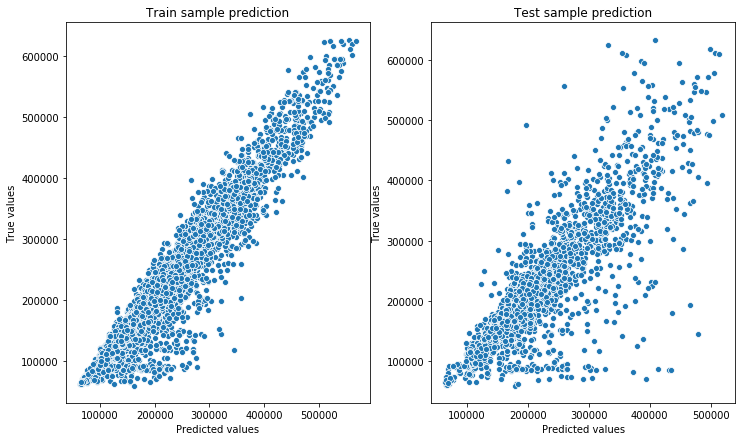

In [58]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_test_preds)

In [59]:
cv_score = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.71272255, 0.73084522, 0.72674762, 0.72297515, 0.768785  ])

In [60]:
cv_score.mean()

0.7324151096413707

In [61]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,Square,0.418502
15,Social_2,0.106472
14,Social_1,0.096694
11,Rooms,0.073227
16,Social_3,0.057897
0,DistrictId,0.048522
1,Ecology_1,0.038521
10,LifeSquare,0.027954
8,HouseYear,0.027605
7,HouseFloor,0.023623


### Работа с тестовыми данными

In [62]:
test_df['Price'] = model.predict(test_df)
test_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Price
Id,,,,,,,,,,,,,,,,,,,
725,58,0.310199,1,1,6,900.0,0,14.0,1972,6.0,33.432782,2.0,0,1,11,2748,1,49.882643,162358.438742
15856,74,0.075779,1,1,6,900.0,0,6.0,1977,3.0,49.440236,2.0,2,1,6,1437,3,69.263183,227687.023787
5480,190,0.000000,1,1,2,4702.0,5,5.0,1909,12.0,15.948246,1.0,5,1,30,7538,87,13.597819,196124.574817
15664,47,0.101872,1,1,22,900.0,3,22.0,2007,9.0,51.940842,2.0,3,1,23,4583,3,73.046609,350202.706287
14275,27,0.072158,1,1,17,900.0,0,17.0,2017,3.0,43.387569,1.0,0,0,2,629,1,47.527111,140580.679992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,0.000170,1,1,5,900.0,1,9.0,1973,6.0,50.809797,3.0,1,1,36,5992,0,67.133911,246944.757288
4695,1,0.007122,1,1,12,900.0,0,17.0,2017,10.0,21.807061,1.0,1,1,1,264,0,40.198472,136926.669804
5783,12,0.090799,1,1,23,900.0,5,23.0,1989,9.0,48.282625,3.0,15,1,74,19083,2,77.842178,327941.856936


In [68]:
test_df

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square,Price
Id,,,,,,,,,,,,,,,,,,,
725,58,0.310199,1,1,6,900.0,0,14.0,1972,6.0,33.432782,2.0,0,1,11,2748,1,49.882643,162358.438742
15856,74,0.075779,1,1,6,900.0,0,6.0,1977,3.0,49.440236,2.0,2,1,6,1437,3,69.263183,227687.023787
5480,190,0.000000,1,1,2,4702.0,5,5.0,1909,12.0,15.948246,1.0,5,1,30,7538,87,13.597819,196124.574817
15664,47,0.101872,1,1,22,900.0,3,22.0,2007,9.0,51.940842,2.0,3,1,23,4583,3,73.046609,350202.706287
14275,27,0.072158,1,1,17,900.0,0,17.0,2017,3.0,43.387569,1.0,0,0,2,629,1,47.527111,140580.679992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,11,0.000170,1,1,5,900.0,1,9.0,1973,6.0,50.809797,3.0,1,1,36,5992,0,67.133911,246944.757288
4695,1,0.007122,1,1,12,900.0,0,17.0,2017,10.0,21.807061,1.0,1,1,1,264,0,40.198472,136926.669804
5783,12,0.090799,1,1,23,900.0,5,23.0,1989,9.0,48.282625,3.0,15,1,74,19083,2,77.842178,327941.856936


In [83]:
test_df = test_df.reset_index('Id')

# была ошибка KeyError: "['Id'] not in index"

In [84]:
test_df_result_csv = test_df[['Id','Price']]
test_df_result_csv.to_csv('/Users/andrewvolkov/Documents/Prog/Datasets/real_estate_project/result.csv',index=False)
test_df_result_csv.tail()

,Id,Price
4995,8180,246944.757288
4996,4695,136926.669804
4997,5783,327941.856936
4998,4780,207562.443981
4999,12504,183088.399237


In [85]:
test_df_result_csv.shape

(5000, 2)